In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), nn.ReLU(),
                         nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1))
                         

In [4]:
class dense_block(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(dense_block, self).__init__()
        layers = []
        for i in range(num_convs):
            layers.append(conv_block(input_channels + num_channels* i, num_channels))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        for layer in self.net:
            y = layer(X)
            X = torch.cat((X,y), dim=1)
        return X

In [5]:
blk = dense_block(2, 3, 10)

X = torch.randn(4,3,8,8)

y = blk(X)
y.shape

torch.Size([4, 23, 8, 8])

In [6]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
        
    )

In [7]:
blk = transition_block(23,10)
blk(y).shape

torch.Size([4, 10, 4, 4])

In [8]:
# creating Densenet

b1 = nn.Sequential(nn.Conv2d(1,64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [13]:
num_channels = 64
growth_rate = 32

num_of_convs_in_dense_blocks = [4,4,4,4]

blks = []

for i, num_convs in enumerate(num_of_convs_in_dense_blocks):
    blks.append(dense_block(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_of_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels//2))
        num_channels = num_channels // 2

In [15]:
net= nn.Sequential(b1, *blks, nn.BatchNorm2d(num_channels),nn.ReLU(),
                   nn.AdaptiveMaxPool2d((1,1)), nn.Flatten(), nn.Linear(num_channels, 10))

loss 0.152, train acc 0.944, test acc 0.857
697.6 examples/sec on cuda:0


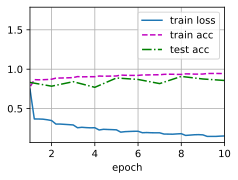

In [16]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [17]:
from torchsummary import summary

summary(net, (3,96,96))

RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[2, 3, 96, 96] to have 1 channels, but got 3 channels instead

## Exercises
1. Why do we use average pooling rather than maximum pooling in the transition layer?
- so that theother cells may not be eliminated and have some value addition in the model

2. One of the advantages mentioned in the DenseNet paper is that its model parameters are
smaller than those of ResNet. Why is this the case?
- because of less number of linear layers, more memory is utilised instead disk space( I am ssuming because of the follow up question given below)

3. One problem for which DenseNet has been criticized is its high memory consumption.
    1. Is this really the case? Try to change the input shape to 224 × 224 to see the actual GPU
    memory consumption.
    - all right weiil have to try
    
    2. Can you think of an alternative means of reducing the memory consumption? How
    would you need to change the framework?
    - no Idea
4. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper
(Huang et al., 2017).

- https://arxiv.org/pdf/1608.06993.pdf

5. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price
prediction task in Section 4.10.

-  This is a task! But how? I am low on motivation.
